In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [198]:
n = 140
lh = 0.15

x,y = np.linspace(0,1,n),np.linspace(0,1,n)
X,Y = np.meshgrid(x,y)

X0 = np.exp( - np.linalg.norm(np.array([X-0.6,Y-0.4]),axis=0)**2/lh**2)

## choosing a wind field and an initial concentration :

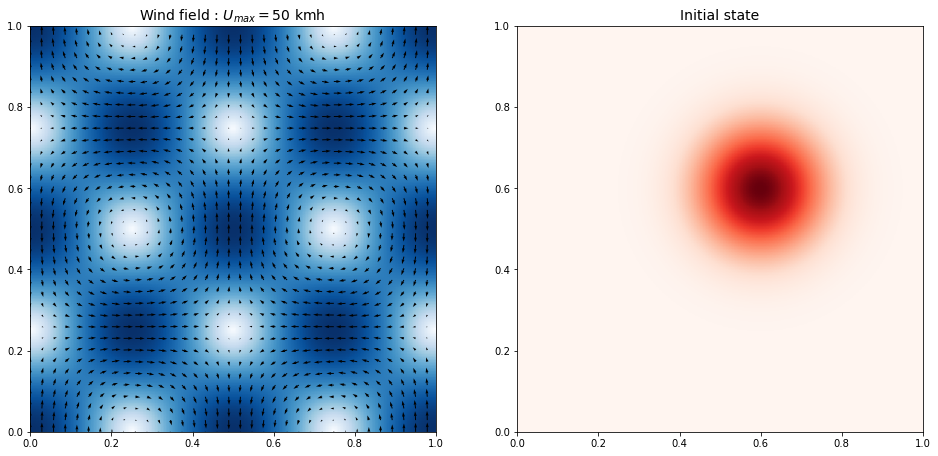

In [205]:
from matplotlib import colors, cm
ex, ey = np.eye(2)
wind_x = np.sin(2*np.pi*X)*np.sin(2*np.pi*Y)
wind_y = np.cos(2*np.pi*X)*np.cos(2*np.pi*Y)

wind = np.array([wind_x,wind_y])
wind_x = wind[0][np.newaxis].T  * ex
wind_y= wind[1][np.newaxis].T* ey



D = 1000 #km
wind = wind / np.linalg.norm(wind,axis=0).max()
max_wind_velocity = 50 #kmh
wind = wind * max_wind_velocity / D


fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(1,2,1)
length = .05


strength = np.linalg.norm(wind,axis=0)
norm=colors.Normalize(vmin = np.min(strength),
                      vmax = np.max(strength), clip = False)


ax.set_title(r"Wind field : $U_{max} = 50$ kmh ",fontsize=14)
ax.quiver(X[::4,::4],Y[::4,::4],wind[0][::4,::4], wind[1][::4,::4])
surface = ax.imshow(np.flip(strength,axis=1).T,extent=[0,1,0,1],cmap=cm.Blues) 

ax2 = fig.add_subplot(1,2,2)
ax2.set_title("Initial state",fontsize=14)
ax2.imshow(X0,extent=[0,1,0,1],cmap=cm.Reds);

## defining the 2D advection problem :

In [200]:
from mypackage.problem import Model
from mypackage.domain import Domain2D

class Advection2D(Model):
    def _make_trend(self):
        Ux, Uy = self.trend_parameters[0]  #theta/ phi : latitute/longitude
        self.domain = Domain2D(len(Ux),len(Uy))
        #computing appropriate timestep :
        sup_Ux = np.linalg.norm(Ux,ord=np.inf)
        sup_Uy = np.linalg.norm(Uy,ord=np.inf)
        self.dt = min(self.domain.dx/sup_Ux, self.domain.dy/sup_Uy) *0.9
        def trend(state,t):
            dx_state = self.domain.derive(state,axis=1) #derive par rapport a x : axis = 1
            dy_state = self.domain.derive(state,axis=0) #derive par rapport a phi : axis = 0
            trend_state =  -Ux * dx_state - Uy*dy_state
            return trend_state
        return trend
    

domain2d = Domain2D(n,n)

## forecast :

100%|███████████████████████████████████████████████████████████████████████████████| 697/697 [00:04<00:00, 164.73it/s]


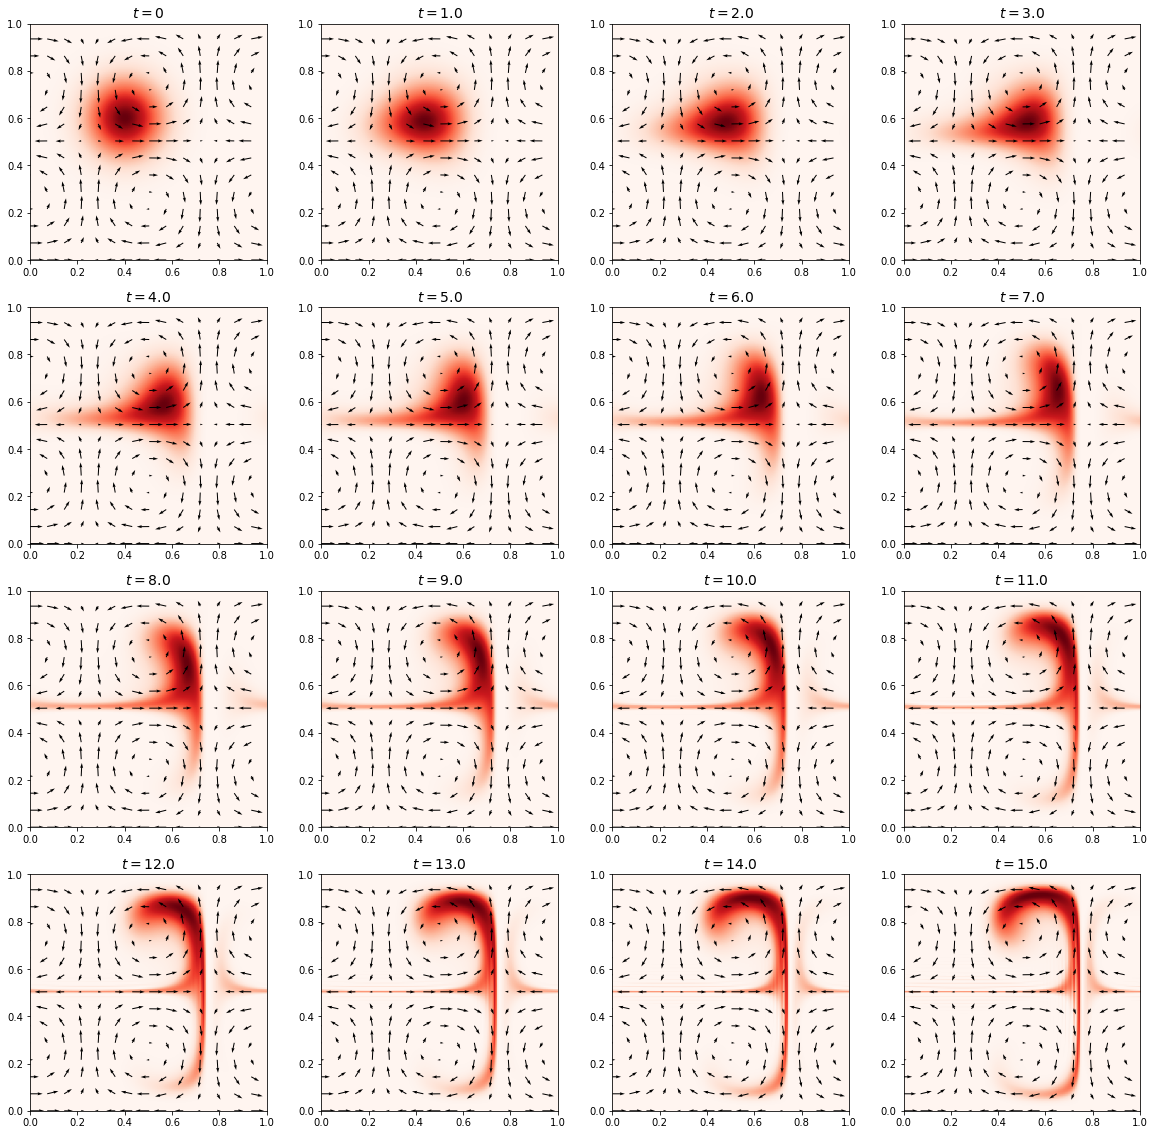

In [204]:
advection2d = Advection2D(X0, [wind],scheme='RK4')
fig, ax = plt.subplots(4,4,figsize=(20,20))
i=0
ds = int(10)
ax.flat[i].quiver(X[::ds,::ds],Y[::ds,::ds],wind[1][::ds,::ds], wind[0][::ds,::ds])
surface = ax.flat[i].imshow(np.flip(advection2d.x,axis=1).T,extent=[0,1,0,1],cmap=cm.Reds,vmin=0,vmax=1) 

ax.flat[i].set_title(f"$t=${advection2d.t}",fontsize=14)
    
for i in range(1,16):
    advection2d.forecast(forecast_horizon=1)
    norm=colors.Normalize(vmin = np.min(strength),
                          vmax = np.max(strength), clip = False)
    ax.flat[i].quiver(X[::ds,::ds],Y[::ds,::ds],wind[1][::ds,::ds], wind[0][::ds,::ds])
    surface = ax.flat[i].imshow(np.flip(advection2d.x,axis=1).T,extent=[0,1,0,1],cmap=cm.Reds,vmin=0,vmax=1) 

    ax.flat[i].set_title(f"$t=${advection2d.t}",fontsize=14)
    
plt.show()